# Behavioral Cloning

In [1]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn.utils
import sklearn.model_selection
print('Tensorflow version {0}'.format(tf.__version__))
print('Keras version {0}'.format(keras.__version__))

Using TensorFlow backend.


Tensorflow version 1.3.0
Keras version 2.0.8


## File I/O
Want to read in a directory of jpg files and write out hdf5

In [2]:
log = pd.read_csv('./driving_data/driving_log.csv', names=['CenterImg', 'LeftImg', 'RightImg', 
                                                           'SteeringAngle', 'Throttle', 'Break', 'Speed'])
log.head()

,CenterImg,LeftImg,RightImg,SteeringAngle,Throttle,Break,Speed
0,/home/sketchc89/Simulated-Driving/driving_data...,/home/sketchc89/Simulated-Driving/driving_data...,/home/sketchc89/Simulated-Driving/driving_data...,0.0,1,0,30.19034
1,/home/sketchc89/Simulated-Driving/driving_data...,/home/sketchc89/Simulated-Driving/driving_data...,/home/sketchc89/Simulated-Driving/driving_data...,0.0,1,0,30.19031
2,/home/sketchc89/Simulated-Driving/driving_data...,/home/sketchc89/Simulated-Driving/driving_data...,/home/sketchc89/Simulated-Driving/driving_data...,0.0,1,0,30.19028
3,/home/sketchc89/Simulated-Driving/driving_data...,/home/sketchc89/Simulated-Driving/driving_data...,/home/sketchc89/Simulated-Driving/driving_data...,0.0,1,0,30.19031
4,/home/sketchc89/Simulated-Driving/driving_data...,/home/sketchc89/Simulated-Driving/driving_data...,/home/sketchc89/Simulated-Driving/driving_data...,0.0,1,0,30.19032


In [3]:
log.describe()

,SteeringAngle,Throttle,Break,Speed
count,10028.000000,10028.0,10028.0,10028.000000
mean,0.017134,1.0,0.0,30.189220
std,0.086484,0.0,0.0,0.032535
min,-0.660747,1.0,0.0,28.195130
25%,0.000000,1.0,0.0,30.189980
50%,0.000000,1.0,0.0,30.190240
75%,0.046948,1.0,0.0,30.190300
max,0.583741,1.0,0.0,30.695000


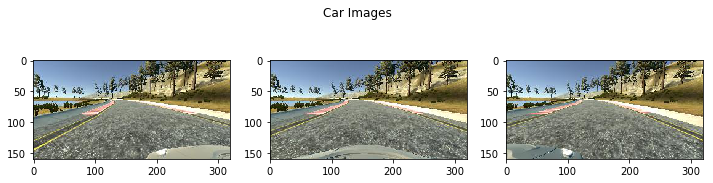

In [4]:
center = mpimg.imread(log['CenterImg'][0])
left = mpimg.imread(log['LeftImg'][0])
right = mpimg.imread(log['RightImg'][0])
fig = plt.figure(figsize=(12,3))
plt.suptitle('Car Images')
axl = plt.subplot(1,3,1)
plt.imshow(left)
axc = plt.subplot(1,3,2)
plt.imshow(center)
axr = plt.subplot(1,3,3)
plt.imshow(right)
plt.show()

### L-R Camera compensation

A correction factor of 0.1 degrees is added to the left camera and subtracted from the right camera to compensate for the lateral position of the camera relative to the center. The value of the correction factor should be evaluated.

In [31]:
images = []
measurements = []
image_path = []
for i in range(log.shape[0]):
    #Original
    center = mpimg.imread(log['CenterImg'][i])
    left = mpimg.imread(log['LeftImg'][i])
    right = mpimg.imread(log['RightImg'][i])
    images.append(center)
    images.append(left)
    images.append(right)
    measurements.append(log['SteeringAngle'][i])
    measurements.append(log['SteeringAngle'][i]+0.1)
    measurements.append(log['SteeringAngle'][i]-0.1)
    image_path.append(log['CenterImg'][i])
    image_path.append(log['LeftImg'][i])
    image_path.append(log['RightImg'][i])
#     #Flipped
#     center_flip = np.fliplr(center)
#     left_flip = np.fliplr(left)
#     right_flip = np.fliplr(right)
#     images.append(center_flip)
#     images.append(left_flip)
#     images.append(right_flip)
#     measurements.append(-log['SteeringAngle'][i])
#     measurements.append(-log['SteeringAngle'][i]-0.1)
#     measurements.append(-log['SteeringAngle'][i]+0.1)

### Unbalanced Classes
We would like to have an equal distribution of steering angles to reduce the bias for zero driving angle. We will apply sample weights to balance the effect of each class.

In [9]:
def bin_angles(y, n_bins = 20):
    '''Computes a bin number for each steering angle in order to balance classes'''
    return np.floor((y - np.min(y))*n_bins/(np.max(y) - np.min(y)))

def bin_weights(y):
    '''Balances numbered classes and returns array of weights to apply to each class'''
    class_weight = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
    class_dict = dict(enumerate(class_weight))
    return np.vectorize(class_dict.get)(y)

In [32]:
X = np.array(images)
y = np.array(measurements)
y_bins = bin_angles(y)
y_weights = bin_weights(y_bins)

X_train, X_test, y_train, y_test, y_train_weights, y_test_weights = sklearn.model_selection.train_test_split(
                                                                            X, y, y_weights, 
                                                                            test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val, y_train_weights, y_val_weights = sklearn.model_selection.train_test_split(
#                                                                     X_train, y_train, y_train_weights, 
#                                                                     test_size=0.25, random_state=1)

Save files to directory so that we can read them with `flow_from_directory`. Shoving them into an array causes memory errors.

In [22]:
import shutil
for i in range(X_train.shape[0]):
    shutil.copy(X_train[i], './driving_data/train/{0:06d}.jpg'.format(i))
for i in range(X_val.shape[0]):
    shutil.copy(X_val[i], './driving_data/val/{0:06d}.jpg'.format(i))
for i in range(X_test.shape[0]):
    shutil.copy(X_test[i], './driving_data/test/{0:06d}.jpg'.format(i))

(array([  1.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          1.00000000e+01,   2.80000000e+01,   1.03000000e+02,
          1.25000000e+02,   2.83000000e+02,   8.14000000e+02,
          3.95100000e+03,   3.89300000e+03,   2.88200000e+03,
          4.20400000e+03,   1.14000000e+03,   3.78000000e+02,
          1.53000000e+02,   6.00000000e+01,   1.70000000e+01,
          1.00000000e+00,   1.00000000e+00]),
 array([-0.7607468 , -0.69020946, -0.61967211, -0.54913477, -0.47859742,
        -0.40806008, -0.33752273, -0.26698539, -0.19644804, -0.1259107 ,
        -0.05537335,  0.01516399,  0.08570134,  0.15623868,  0.22677603,
         0.29731337,  0.36785072,  0.43838806,  0.50892541,  0.57946275,
         0.6500001 ]),
 <a list of 20 Patch objects>)

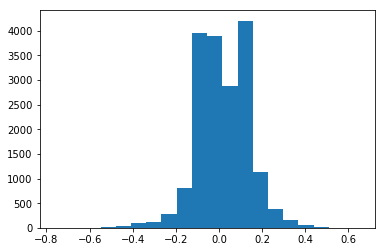

In [29]:
%matplotlib inline
plt.hist(y_train, bins=20)
#log['SteeringAngle'].plot()

### Image Generator
* Images are flipped in order to reduce bias towards driving on slightly towards one side of the road.
* ZCA Whitening is applied
* Image generator probably won't work without classes

In [28]:
# img_width=320
# img_height=160
# batch_size=32
# datagen = keras.preprocessing.image.ImageDataGenerator(
#             featurewise_center=True,
# #             featurewise_std_normalization=False,
#             zca_whitening=True,
#             horizontal_flip=True)
# datagen.flow_from_directory('./driving_data/train/',
#                             target_size=(img_width, img_height),
#                             batch_size=batch_size,
#                             class_mode=None, 
#                             classes=None)

Found 18050 images belonging to 1 classes.


In [6]:
history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch =  y_train.shape[0],
                                     sample_weight = y_train_weights
                                     validation_data = validation_generator,
                                     nb_val_samples = y_val.shape[0],
                                     nb_epoch=5, verbose=2)

NameError: name 'model' is not defined

In [33]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D
from keras.layers import MaxPooling2D, Cropping2D

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/255.0 - 0.5))
model.add(Conv2D(24, (5,5), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(36, (5,5), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(48, (5,5), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2, 
          sample_weight=y_train_weights, shuffle=True, verbose=2)
model.save('model.h5')

Train on 19253 samples, validate on 4814 samples
Epoch 1/10
31s - loss: 0.2040 - val_loss: 0.0214
Epoch 2/10
25s - loss: 0.1118 - val_loss: 0.0928
Epoch 3/10
25s - loss: 9.9192 - val_loss: 2.0554
Epoch 4/10
25s - loss: 2.1686 - val_loss: 0.0887
Epoch 5/10
25s - loss: 0.3237 - val_loss: 0.0967
Epoch 6/10
25s - loss: 0.3176 - val_loss: 0.0681
Epoch 7/10
25s - loss: 0.3149 - val_loss: 0.0651
Epoch 8/10
25s - loss: 0.2225 - val_loss: 0.0315
Epoch 9/10
25s - loss: 0.1372 - val_loss: 0.0797
Epoch 10/10
25s - loss: 0.0984 - val_loss: 0.0272


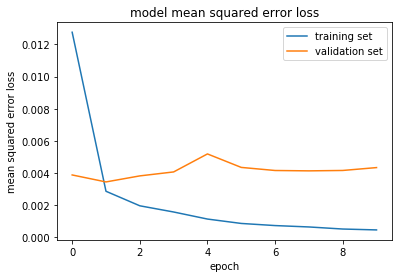

In [10]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [81]:
min_samples = 50
n_bins = 20
X_train = np.array(image_path)
y_train = np.array(measurements)
hist, bins = np.histogram(y_train, bins=n_bins)
hist_min = hist[hist > min_samples]
binz = bins[:-1]
bins_min = binz[hist > min_samples] * 

# bins_width = (np.max(y_train) - np.min(y_train)) / n_bins

(12,)